In [5]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import norm, multivariate_normal
from sklearn.model_selection import train_test_split

# GMM

In this notebook, we will explore the GMM algorithm in its simplest form.
The data can be generated as in the previous notebook.

Text(0, 0.5, '$x_2$')

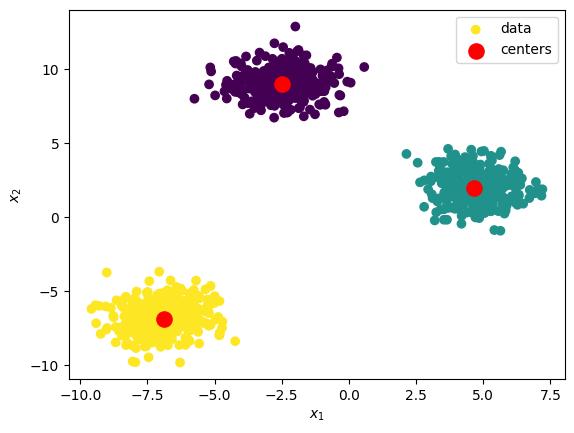

In [6]:
X,y,centers = make_blobs(
    n_samples=1000,
    n_features=2,
    return_centers=True,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(centers[:,0], centers[:,1], c='r', s=120)
plt.legend(["data", "centers"])
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

## Fitting normal distribution to data
use `norm.fit` and `norm.pdf` to evaluate pdf for plotting

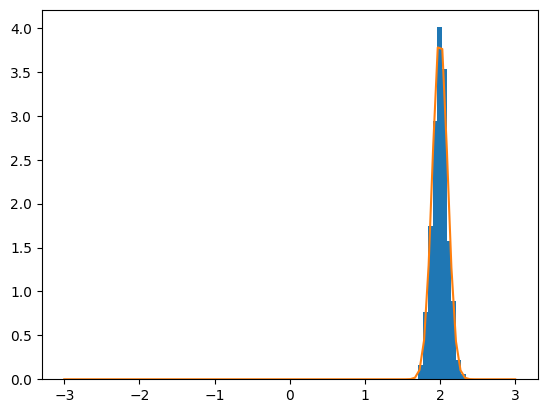

In [7]:
data = np.random.randn(1000)/10 + 2
plt.hist(data, density=True)

mu, std = norm.fit(data)

x_plot = np.linspace(-3,3,100)
plt.plot(x_plot, norm.pdf(x_plot, mu, std))

For multivariate normal distribution, we can use `multivariate_normal` from `scipy.stats`

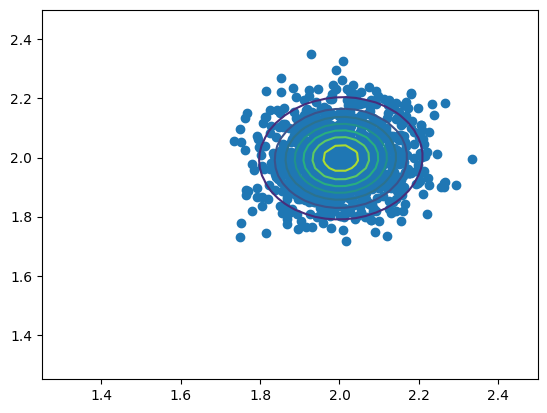

In [8]:
data = np.random.randn(1000,2)/10 + 2
plt.scatter(data[:,0], data[:,1])

def plot_mv_normal(mu,sigm,low,high,res):
    grid_1d=np.linspace(low,high,res)
    xx,yy = np.meshgrid(grid_1d,grid_1d)

    d = multivariate_normal(mu,sigm)
    z = d.pdf(np.dstack((xx,yy)))
    return plt.contour(grid_1d,grid_1d,z)

mu, std = multivariate_normal.fit(data)

plot_mv_normal(mu,std, 1.25, 2.5, 50)

You can start from K-means clustering, but:
- Each cluster is a normal distribution, parameterized by its mean and covariance
- Instead of calculating the distance to the cluster center, we calculate the probability of each point belonging to each cluster
- We can assign each point to the cluster with the highest probability
- The parameters of the normal distributions are updated using the points assigned to each cluster
- The process is repeated until convergence

In [ ]:
class GMM_demo:
    def __init__(self, K, max_iters=20, tol=1e-8):
        self.K = K
        self.max_iters = max_iters
        self.tol = tol
        indices = np.random.choice(X.shape[0], size=self.K, replace=False)
        self.means = X[indices]
        self.covariance = np.array([np.cov(X.T) for _ in range(self.K)])
        
    def fit(self,X):
        
        #expectation Step
        likelihoods = np.zeros((len(X), self.K))  # shape: (3,3)
        for i, x in enumerate(X):
            for k, (mu, cov) in enumerate(zip(self.means, self.covariance)):
                rv = multivariate_normal(mean=mu, cov=cov)
                likelihoods[i, k] = rv.pdf(x)
        gamma = np.argsort(likelihoods, axis=1)[:, -1]
        
        iteration = 0
        while iteration < self.max_iters: #Abbruchkriterien
            iteration += 1
            
            #expectation step
            likelihoods = np.zeros((len(X), self.K))  # shape: (3,3)
            for i, x in enumerate(X):
                for k, (mu, cov) in enumerate(zip(self.means, self.covariance)):
                    rv = multivariate_normal(mean=mu, cov=cov)
                    likelihoods[i, k] = rv.pdf(x)
            gamma = np.argsort(likelihoods, axis=1)[:, -1]
            
            #Maximization step, new parameters via log-likelihood maximization
            new_means = []
            new_covariances = []

            for k in range(self.K):
                cluster_data = X[gamma == k]
                if len(cluster_data) > 0:
                    mu_k = cluster_data.mean(axis=0)
                    cov_k = np.cov(cluster_data, rowvar=False)
                else:
                    mu_k = self.means[k]
                    cov_k = self.covariance[k]

                new_means.append(mu_k)
                new_covariances.append(cov_k)

            new_means = np.array(new_means)
            new_covariances = np.array(new_covariances)
            self.means = new_means
            self.covariance = new_covariances


    def predict(self, X):
        distances = cdist(X, self.cluster_centroids, metric='euclidean')  #Distanzmatrix
        gamma = np.argmin(distances, axis=1)
        print(self.cluster_centroids)
        return gamma
    


In [12]:
mod = GMM_demo(K=3)
mod.fit(X)

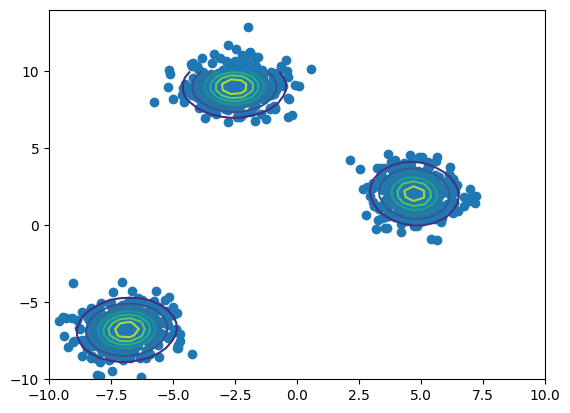

In [14]:
plt.scatter(X[:,0], X[:,1])
for k in range(mod.K):
    plot_mv_normal(mod.means[k],mod.covariance[k],-10,10,50)